<a href="https://colab.research.google.com/github/wicky818/UTKFace_Deep_Learning/blob/main/UTKFace_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb -q
!pip install tensorflow-gpu

     |████████████████████████████████| 1.8 MB 5.0 MB/s 
     |████████████████████████████████| 145 kB 72.8 MB/s 
     |████████████████████████████████| 181 kB 49.3 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 511.7 MB 3.9 kB/s 
     |████████████████████████████████| 5.8 MB 50.6 MB/s 
     |████████████████████████████████| 438 kB 59.4 MB/s 
     |████████████████████████████████| 1.6 MB 37.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempti

# Getting Data

In [2]:
!git clone https://github.com/wicky818/UTKFace_Deep_Learning.git

Cloning into 'UTKFace_Deep_Learning'...
remote: Enumerating objects: 23326, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 23326 (delta 0), reused 3 (delta 0), pack-reused 23323
Receiving objects: 100% (23326/23326), 110.09 MiB | 38.55 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (33489/33489), done.


In [3]:
!ls

sample_data  UTKFace_Deep_Learning


In [4]:
import os

os.chdir("/content/UTKFace_Deep_Learning")
images = os.listdir('/content/UTKFace_Deep_Learning/dataset/UTKFace')
print('Total number of images: ', len(images))

Total number of images:  23708


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Loading Data

[age] is an integer from 0 to 116, indicating the age\
[gender] is either 0 (male) or 1 (female)\
[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).\
[date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

In [14]:
images = []
ages = []
genders = []
race = []

for i in os.listdir('/content/UTKFace_Deep_Learning/dataset/UTKFace'):
    split = i.split('_')
    ages.append((split[0]))
    genders.append((split[1]))
    race.append((split[2]))

    images.append(Image.open('/content/UTKFace_Deep_Learning/dataset/UTKFace/' + i))

In [17]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')
race = pd.Series(list(race), name = 'Races')

df = pd.concat([images, ages, genders, race], axis=1)
df["Ages"] = df["Ages"].astype(int)
df["Genders"] = df["Genders"].astype(int)
df["Races"] = df["Races"].astype(int)

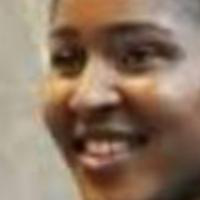

26 1 1


In [20]:
display(df['Images'][0])
print(df['Ages'][0], df['Genders'][0], df['Races'][0])